In [3]:
%matplotlib inline
from spectral_cube import SpectralCube
from aplpy import FITSFigure
import numpy as np
import os
from astropy.io import fits
import astropy.units as u
import warnings
import numpy as np
import shells
import shell_model
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Fixing Model Cloud Parameters for Orion A
distance: 414 pc (Menten+ 2007)

thickness: 1 pc (upper limit: ~ largest shell radius

fwhm: 4 km/s (from maps below)

beta: 2 power spectrum (http://adsabs.harvard.edu/abs/1994ApJ...429..645M)

### Calculate Velocity FWHM from NRO Data

In [4]:
cubefile12co = "../nro_maps/12CO_20161017_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms_YS.fits"
regionfile = "../shell_candidates/AllShells.reg"

In [5]:
cube = SpectralCube.read(cubefile12co)
mom0_map = cube.moment0()
fwhm_map = cube.linewidth_fwhm() 

3807.0892100097462 m / s


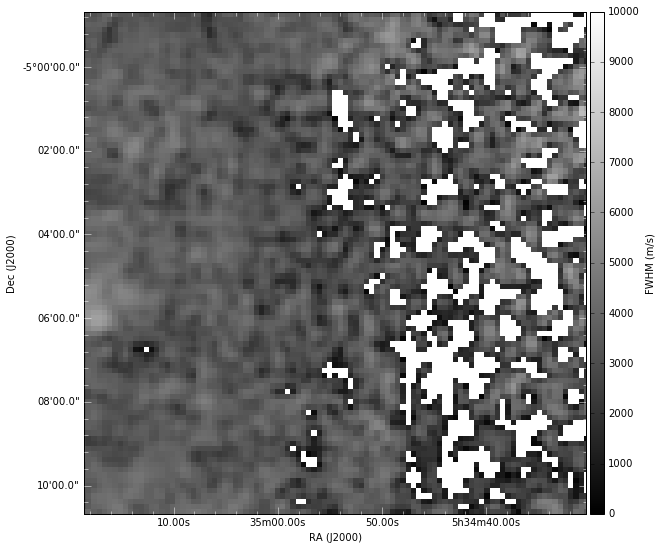

In [6]:
print(np.nanmedian(fwhm_map))

fig = FITSFigure(fwhm_map.hdu)
fig.show_grayscale(vmin=0, vmax=10000)
fig.recenter(83.72707, -5.07792, 0.1)
fig.show_colorbar()
fig.colorbar.set_axis_label_text("FWHM (m/s)")

### Smooth the Velocity FWHM Map For a Global Estimate of FWHM in Orion A

3808.10480004


INFO: Auto-setting vmin to  1.446e+03 [aplpy.core]
INFO: Auto-setting vmax to  8.218e+03 [aplpy.core]


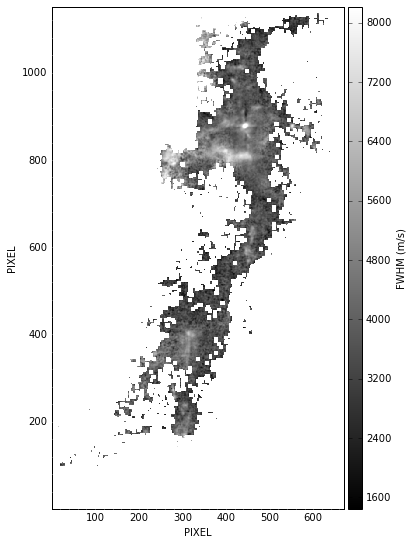

In [7]:
from scipy.ndimage.filters import gaussian_filter
fwhm_smooth = gaussian_filter(fwhm_map.data, 1)
print(np.nanmedian(fwhm_smooth))
fig = FITSFigure(fwhm_smooth)
fig.show_grayscale()
#fig.recenter(83.72707, -5.07792, 0.1)
fig.show_colorbar()
fig.colorbar.set_axis_label_text("FWHM (m/s)")

### Plot an example turbulent model cube.

In [160]:
# For Shell 18
n=17
shell_list = shells.get_shells()
shell = shell_list[n]

outfile = '../turbulent_model/shell18_nocloud.fits'
model_pars = {
    'outfile':"'{}'".format(outfile),
    'dist':414, # pc
    'pix_size':7.5, # arcsec
    'vstep':0.099, # km/s
    'acen':shell.ra.value, # deg
    'dcen':shell.dec.value, # deg
    'thickness':0.0, # pc
    'fwhm':0.0, # km/s
    'beta':0.0, # spectral index
    'r':0.22, # pc
    'dr':0.2, # pc
    'vexp':2.2, # km/s
    'depth_offset':0.0, # pc
    'vel_offset':0.0, # km/s
    'v0':13.6, # km/s
    'ignore_cloud':1 #Ignore cloud.
             }
idl_arg_list = ["{}={}".format(k, v) for k, v in model_pars.items()]

idl_arg_string = ', '.join(idl_arg_list)
#call_string = "idl << EOF \n" +\
#              ".r turbulent_model \n" +\
#              "turbulent_model, {} \n".format(idl_arg_string) +\
#              "EOF"
call_string = 'idl -e "turbulent_model, {}"'.format(idl_arg_string)

In [161]:
#Call the idl program turbulent_model.pro with the above parameters
e = os.system(call_string)

### Integrated Intensity (Column Density) of Model Shell

In [162]:
model_cube = SpectralCube.read(outfile)
model_mom0 = model_cube.moment0()

INFO: Auto-setting vmin to -7.532e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.361e+00 [aplpy.core]


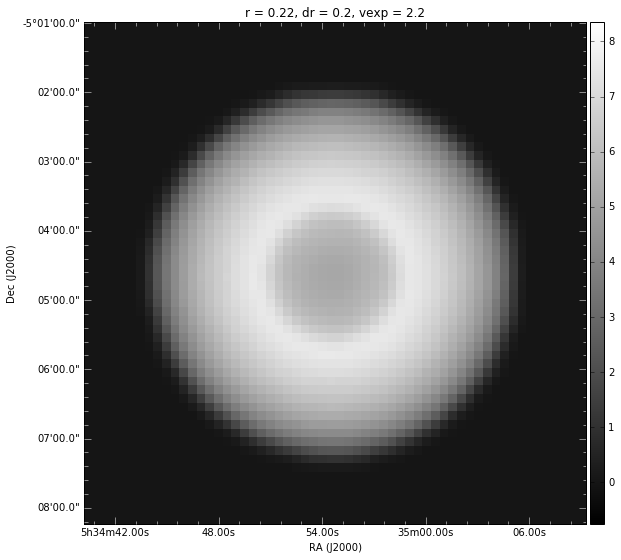

In [163]:
fig = FITSFigure(model_mom0.hdu)
fig.show_grayscale()
cb = fig.show_colorbar()
fig.set_title("r = {}, dr = {}, vexp = {}".format(model_pars['r'], model_pars['dr'], model_pars['vexp']))

### Extract a subcube around an Orion A shell

In [164]:
#n = 40
shell_list = shells.get_shells()
subcubes = shells.subcubes_from_ds9(cube=cubefile12co, region_file=regionfile, pad_factor=1.5, shape='square')
shell = shell_list[n]
shell_subcube = subcubes[n].spectral_slab(shell.vmin, shell.vmax)
shell_mom0 = shell_subcube.moment0()

INFO: Auto-setting vmin to -9.160e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.793e+04 [aplpy.core]


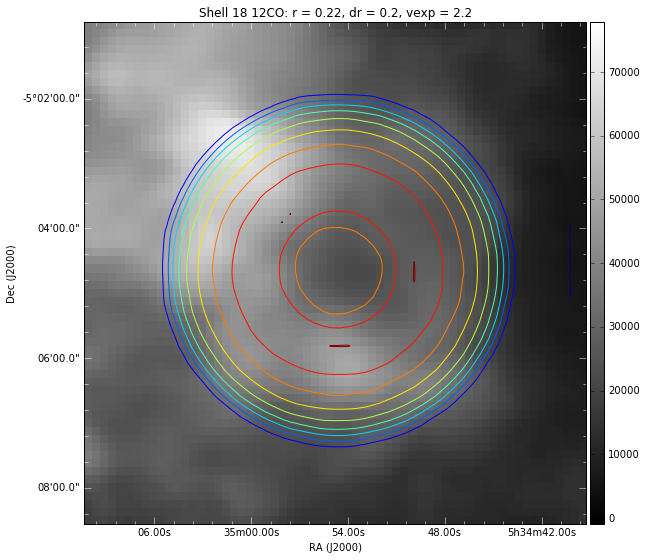

In [165]:
fig = FITSFigure(shell_mom0.hdu)
fig.show_grayscale()
cb = fig.show_colorbar()
fig.set_title("Shell 18 12CO: r = {}, dr = {}, vexp = {}".format(model_pars['r'], model_pars['dr'], model_pars['vexp']))
fig.show_contour(model_mom0.hdu, levels=10)

In [166]:
model_profile, model_profile_error, model_bins = shell_model.radial_profile(np.array(model_mom0), nbins=30)
shell_profile, shell_profile_error, shell_bins = shell_model.radial_profile(np.array(shell_mom0), nbins=30)

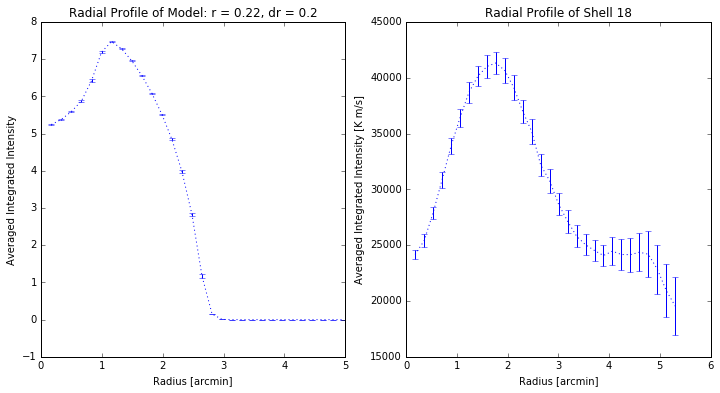

In [167]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.errorbar(model_bins*model_pars['pix_size']/60., model_profile,
             yerr=model_profile_error, linestyle="dotted", label="S.E.M.")
ax1.set_xlabel("Radius [arcmin]")
ax1.set_ylabel("Averaged Integrated Intensity")
ax1.set_title("Radial Profile of Model: r = {}, dr = {}".format(model_pars['r'], model_pars['dr']))

ax2 = fig.add_subplot(122)
ax2.errorbar(shell_bins*model_pars['pix_size']/60., shell_profile,
             yerr=shell_profile_error, linestyle="dotted", label="S.E.M.")
ax2.set_xlabel("Radius [arcmin]")
ax2.set_ylabel("Averaged Integrated Intensity [K m/s]")
ax2.set_title("Radial Profile of Shell {}".format(n+1))

### Plot the normalized profiles against each other.

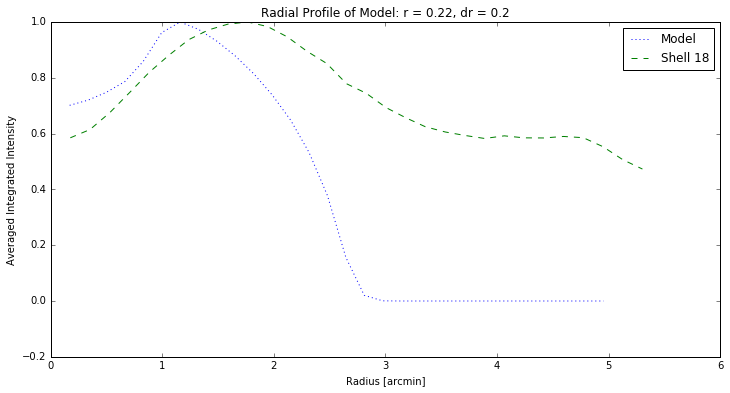

In [168]:
fig = plt.figure(figsize=(12,6))
plt.plot(model_bins*model_pars['pix_size']/60., model_profile/np.nanmax(model_profile),
             linestyle="dotted", label="Model")
plt.plot(shell_bins*model_pars['pix_size']/60., shell_profile/np.nanmax(shell_profile),
             linestyle="dashed", label="Shell 18")
plt.xlabel("Radius [arcmin]")
plt.ylabel("Averaged Integrated Intensity")
plt.legend()
plt.title("Radial Profile of Model: r = {}, dr = {}".format(model_pars['r'], model_pars['dr']))

## Modeling Shell Position-Velocity Diagrams

### Comparison of Model and Observed Shell P-V Cut

In [169]:
#n = 4 #Shell 18
shell = shell_list[n]
subcube = subcubes[n]
pix_size = subcube.spatial_coordinate_map[0][1,0] - subcube.spatial_coordinate_map[0][0,0]
pv_angle = 340 * u.deg
pv_width, pv_length = 3 * pix_size, 3 * shell.radius
pv_obs, path = shells.pv_slice(cube=subcube, ra_center=shell.ra, dec_center=shell.dec,
                     angle=pv_angle, width=pv_width, length=pv_length,
                     return_path=True)
pv_model = shells.pv_slice(cube=model_cube, ra_center=shell.ra, dec_center=shell.dec,
                          angle=pv_angle, width=pv_width, length=pv_length)


INFO: Auto-setting vmin to -5.759e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.603e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.752e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.944e+01 [aplpy.core]


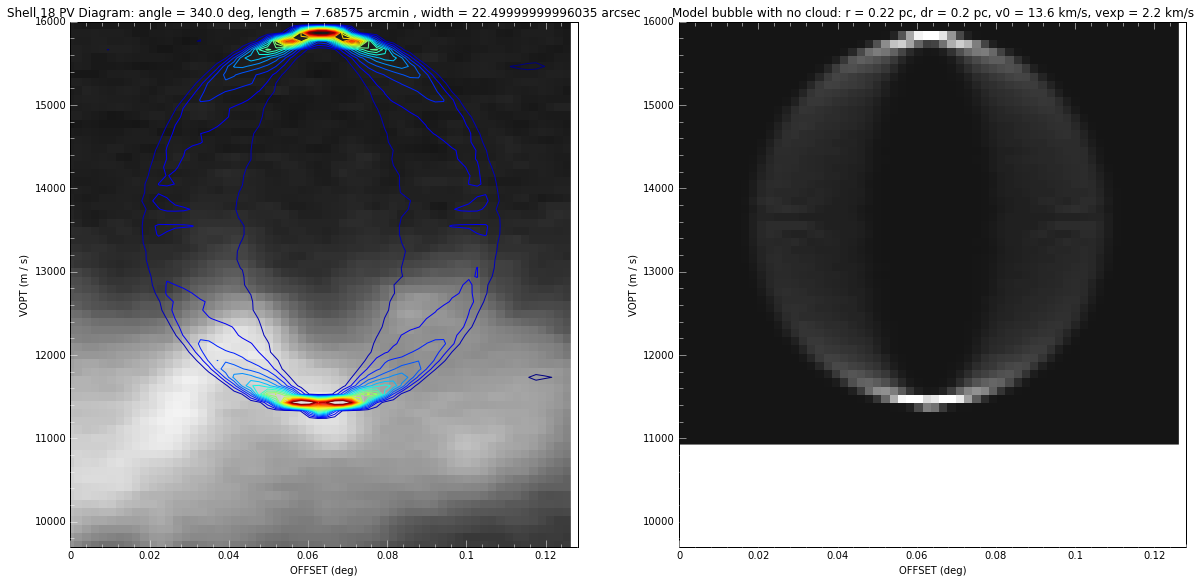

In [170]:
fig = plt.figure(figsize=(20,10))
obsfig = FITSFigure(pv_obs, figure=fig, subplot=(1,2,1))
obsfig.show_grayscale()
obsfig.show_contour(pv_model, levels=20)
obsfig.recenter(pv_length.value / 2., 1000. * (shell.vmax.value + shell.vmin.value) / 2.,
                width=pv_length.value, height = 3*1000*(shell.vmax.value - shell.vmin.value))
obsfig.set_title("Shell {} PV Diagram: angle = {}, length = {} , width = {}".format(
                 n+1, pv_angle, pv_length.to(u.arcmin), pv_width.to(u.arcsec)))

modelfig = FITSFigure(pv_model, figure=fig, subplot=(1,2,2))
modelfig.show_grayscale()
modelfig.set_title(
    "Model bubble with no cloud: r = {} pc, dr = {} pc, v0 = {} km/s, vexp = {} km/s".format(
        model_pars['r'], model_pars['dr'], model_pars['v0'], model_pars['vexp']))
modelfig.recenter(pv_length.value / 2., 1000. * (shell.vmax.value + shell.vmin.value) / 2.,
                width=pv_length.value, height = 3*1000*(shell.vmax.value - shell.vmin.value))
#fig.show_grayscale()

Assuming the position of bubble and the observation parameters stay fixed. The bubble-only model shown above depends should only depend on **v0**, **vexp**, **r**, and **dr**. May need to also fit for the bubble center, **acen** and **dcen**.

### Comparing Azimuthally Averaged P-V Diagrams
Rotate slices through the shell center and find the average P-V diagram.